# Import statements

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV

from sklearn import metrics

# from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Models
from sklearn.linear_model import SGDClassifier # SGD model

# Reading into data frame from file

In [4]:
data_frame = pd.read_csv("../../data/dupes_dropped_creditcard.csv")

# Load models from files if desired

In [3]:
from pickle import load
load_models = False

if load_models:
    with open("SGDClassifier_model.pkl", "rb") as file:
        clf = load(file)
    with open("SGDClassifier_model_resampled.pkl", "rb") as file:
        clf_resampled = load(file)
else:
    clf, clf_resampled = None, None

# Data to fit and targets

In [4]:
old_feature_set = ["Time", "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19", "V20", "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28", "Amount"]
feature_set = ["V10", "V11", "V12", "V14", "V16", "V17"]

target_set = ["Class"]

X = data_frame[feature_set]
y = data_frame[target_set]

# y.head()
# print(y)

# Splits data into 80-20 train-test

Prevents data leakage (where training and test sets influence each other in scaling)

stratify = y tells the function to split proportionally with respect to "Class". This is so the test set doesn't have a different class weight than the train set. I believe this controls for the cases where less of the POSITIVE FRAUD cases show up in the training or test set, reducing overfitting(?).

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# print((y_train["Class"] == 1).sum())
# print((y_test["Class"] == 1).sum())

# Balancing data set with resampling

Produces the same number of fraud and not-fraud cases. Doesn't add any new data so performance improvement is likely small compared to performance loss from fitting twice as many points.

In [6]:
def resample_fraud_dataset(X_train: pd.DataFrame, y_train: pd.DataFrame) -> tuple:
    # Balancing data set with resampling
    # Separate majority and minority classes in training set
    X_train_majority = X_train[y_train["Class"] == 0]
    y_train_majority = y_train[y_train["Class"] == 0]
    
    X_train_minority = X_train[y_train["Class"] == 1]
    y_train_minority = y_train[y_train["Class"] == 1]

    # X_train_majority.head()

    # Oversample minority class, matching number of Fraud and not-Fraud rows with duplication
    X_minority_upsampled, y_minority_upsampled = resample(
        X_train_minority,
        y_train_minority,
        replace=True,  # sample with replacement
        n_samples=len(y_train_majority),  # match majority class
        random_state=1,
    )

    # Combine majority and upsampled minority
    X_train_resampled = pd.concat((X_train_majority, X_minority_upsampled))
    y_train_resampled = pd.concat((y_train_majority, y_minority_upsampled))

    return X_train_resampled, y_train_resampled

In [7]:
X_train_resampled, y_train_resampled = resample_fraud_dataset(X_train, y_train)

In [8]:
# Proof they're resampled
print((y_train_resampled["Class"] == 0).sum())
print((y_train_resampled["Class"] == 1).sum())

print(X_train_resampled.shape[0])
print(y_train_resampled.shape[0])

226602
226602
453204
453204


# Initialize model(s)

In [9]:
if clf == None:
    clf = SGDClassifier(loss='squared_hinge', penalty='l1', random_state=1) # Apparently prefers standard scaling
if clf_resampled == None:
    clf_resampled = SGDClassifier(loss='squared_hinge', penalty='l1', random_state=1)

In [10]:
# Collect predictions from non-resample trained model
if not load_models:
    clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)

In [11]:
# Collect predictions from resample trained model
if not load_models:
    clf_resampled.fit(X_train_resampled, y_train_resampled.values.ravel())
y_resampled_pred = clf_resampled.predict(X_test)

# Hyperparameter Testing

In [12]:
# Defining variables
parameters = {
    # 'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'loss': ['hinge', 'log_loss', 'squared_hinge'],
    # 'learning_rate': ['optimal', 'constant', 'adaptive'],
    # 'max_iter': [1000, 2000, 5000]
}

kf = StratifiedKFold(n_splits=3)

In [13]:
# Grid search on non-resampled model
grid_search = GridSearchCV(clf, parameters, cv=kf, scoring='f1')
# grid_search = GridSearchCV(clf, parameters, cv=kf, scoring='f1', error_score='raise')
grid_search.fit(X_train, y_train.values.ravel())

,estimator,SGDClassifier(random_state=1)
,param_grid,"{'loss': ['hinge', 'log_loss', ...], 'penalty': ['l2', 'l1', ...]}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_hinge'


In [14]:
# Grid search on resampled model
grid_search_resampled = GridSearchCV(clf_resampled, parameters, cv=kf, scoring='f1', error_score='raise')
grid_search_resampled.fit(X_train_resampled, y_train_resampled.values.ravel())

,estimator,SGDClassifier(random_state=1)
,param_grid,"{'loss': ['hinge', 'log_loss', ...], 'penalty': ['l2', 'l1', ...]}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,False
,loss,'squared_hinge'


In [15]:
print("Cross-Validation Score of Best Model Found: ", grid_search.best_score_)
print("Best Parameters Found: ", grid_search.best_params_)

Cross-Validation Score of Best Model Found:  0.07981687038396752
Best Parameters Found:  {'loss': 'squared_hinge', 'penalty': 'l1'}


In [16]:
print("Cross-Validation Score of Best Model Found: ", grid_search_resampled.best_score_)
print("Best Parameters Found: ", grid_search_resampled.best_params_)

Cross-Validation Score of Best Model Found:  0.9224927338676983
Best Parameters Found:  {'loss': 'squared_hinge', 'penalty': 'l1'}


# Metrics

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.87      0.55      0.67        95

    accuracy                           1.00     56746
   macro avg       0.93      0.77      0.84     56746
weighted avg       1.00      1.00      1.00     56746



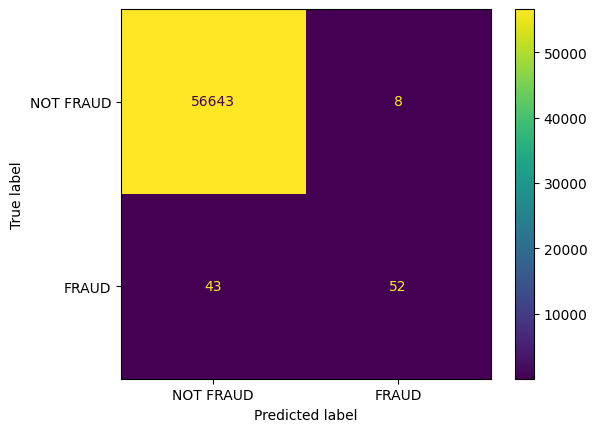

In [12]:
# Metrics for non-resampled model
print(metrics.classification_report(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
metrics.ConfusionMatrixDisplay(cm, display_labels=["NOT FRAUD", "FRAUD"]).plot()

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.08      0.81      0.15        95

    accuracy                           0.98     56746
   macro avg       0.54      0.90      0.57     56746
weighted avg       1.00      0.98      0.99     56746



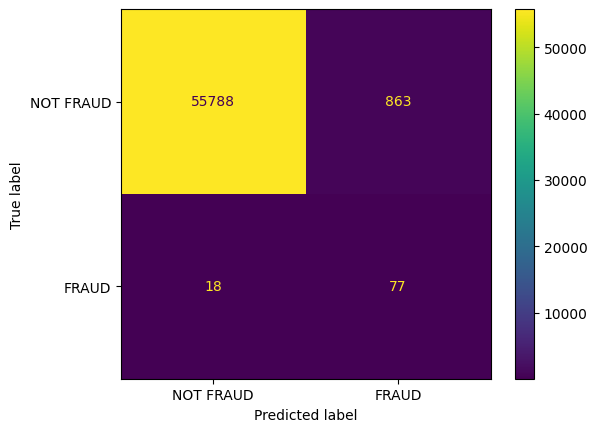

In [13]:
# Metrics for resampled model
print(metrics.classification_report(y_test, y_resampled_pred))
cm_resampled = metrics.confusion_matrix(y_test, y_resampled_pred)
metrics.ConfusionMatrixDisplay(cm_resampled, display_labels=["NOT FRAUD", "FRAUD"]).plot()

## Cross-validation

In [14]:
# Cross validation score for not resampled
kf = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=kf, scoring="f1")
print("Cross validation scores:", cv_scores)
print(f"Mean Validation Score: {np.mean(cv_scores)}")

Cross validation scores: [0.65079365 0.68181818 0.6870229  0.68253968 0.72992701]
Mean Validation Score: 0.6864202846428289


In [15]:
# Cross validation score for resampled
cv_scores_resampled = cross_val_score(clf, X_train_resampled, y_train_resampled.values.ravel(), cv=kf, scoring="f1")
print("Cross Resampled validation scores:", cv_scores_resampled)
print(f"Mean Resampled Validation Score: {np.mean(cv_scores_resampled)}")

Cross Resampled validation scores: [0.93063182 0.93198113 0.92117104 0.93190221 0.9289834 ]
Mean Resampled Validation Score: 0.9289339191812174


## AUPRC

<Figure size 800x600 with 0 Axes>

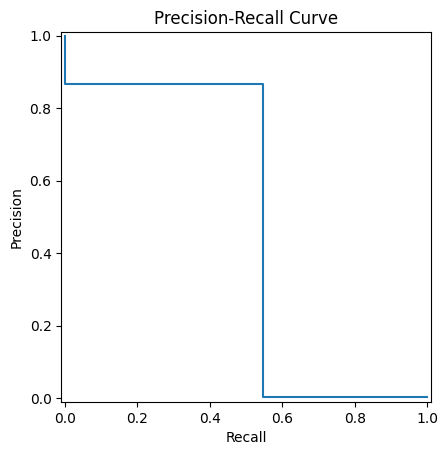

In [16]:
# Display AUPRC for non-resampled
import matplotlib.pyplot as plt

precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(8,6))
display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
display.plot()

plt.title("Precision-Recall Curve")
plt.show()

<Figure size 800x600 with 0 Axes>

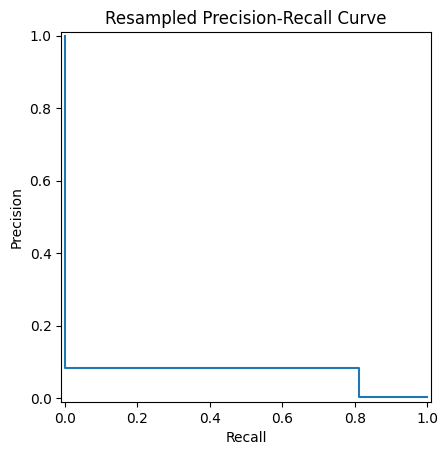

In [17]:
# Display AUPRC for resampled
import matplotlib.pyplot as plt

precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_resampled_pred)
plt.figure(figsize=(8,6))
display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
display.plot()

plt.title("Resampled Precision-Recall Curve")
plt.show()

# Save models to file

In [ ]:
from pickle import dump
save_models = False

if save_models:
    with open ("SGDClassifier_model_resampled.pkl", "wb") as file:
        dump(clf_resampled, file)
    with open ("SGD_Classifier_model.pkl", "wb") as file:
        dump(clf, file)